In [43]:
from sphfile import SPHFile
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from random import randint
import soundfile

In [29]:
def plot_spectrogram(stft, title = "Spectrogtam"):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft), ref=np.max), y_axis='log', x_axis='time', ax=ax)
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [44]:
def compute_stft(audio_data, win_length = 2048, hop_length = 512, n_fft = 2048):
    '''
    Helper method to compute the Short Time Fourier Transform
    '''
    return librosa.stft(audio_data, win_length=win_length, hop_length=hop_length, n_fft= n_fft)

In [6]:
# Comparing SPH data and wav data
sph_data = SPHFile('data/000001.sph')
print(sph_data.content.shape)
print(sph_data.format['sample_sig_bits'])

wav_data, samp_rate = librosa.load('data/000001.wav', sr= sph_data.format['sample_rate'])
# print(wav_data.shape)
print(np.where(wav_data == 0))
print(np.min(wav_data), np.max(wav_data))

# print(sph_data.content/wav_data, 2**(sph_data.format['sample_sig_bits']-1))

(56789,)
16
(array([  151,   468,   607,   852,  1063,  1346,  1391,  1443,  1736,
        2020,  2066,  2207,  2450,  2579,  2636,  2671,  2757,  2843,
        2993,  3405,  3431,  3479,  3546,  3663,  4417,  5843,  8751,
        9551,  9721,  9770,  9885,  9918, 10118, 10235, 10322, 10424,
       15321, 15936, 16155, 17648, 18575, 18809, 19488, 19502, 19608,
       19764, 19809, 19835, 19912, 20216, 20252, 20529, 20536, 20604,
       20629, 21853, 22891, 23541, 23939, 24555, 24958, 25062, 25496,
       25840, 26261, 26272, 26331, 26650, 27057, 27079, 27181, 27198,
       27222, 27233, 27257, 27258, 27261, 27266, 27291, 27319, 27379,
       27443, 27504, 27610, 27651, 27804, 27851, 27880, 28039, 28160,
       28202, 28341, 28361, 28420, 28474, 28485, 28486, 28550, 28597,
       28985, 29021, 29102, 29109, 29402, 29406, 29599, 29609, 29638,
       29675, 29728, 30013, 30144, 30166, 30210, 33286, 33835, 34469,
       34549, 34814, 34888, 35001, 35010, 35239, 35303, 35789, 35876,
       

In [45]:
sph_data = SPHFile('data/clean_data/000005.sph')
SR = sph_data.format['sample_rate']

In [46]:
noise_data = librosa.load('data/raw_data/Single/Office_2/1/Single_803_1_Noise_Babble.wav', sr=SR)

In [47]:
noise_data[0].shape

(2274993,)

In [48]:
# Mixing noise with clean speech
clean_signal = sph_data.content/(2**(sph_data.format['sample_sig_bits']-1))
noise_signal = noise_data[0]
# print(clean_signal)
# print(noise_signal)

alpha = 0.9    # control noise
len_signal = clean_signal.shape[0]
print('Length of signal -- %d' %(len_signal))
start_n = randint(0,noise_signal.shape[0]-clean_signal.shape[0])

# randomly sample a window from noise sequence to be mixed
noise_signal = noise_signal[start_n: start_n+len_signal]
mixed_signal = alpha*clean_signal + (1-alpha)*noise_signal

soundfile.write('mix_speech.wav', mixed_signal, SR)

Length of signal -- 105216


(1025, 206) (1025, 206) (1025, 206)


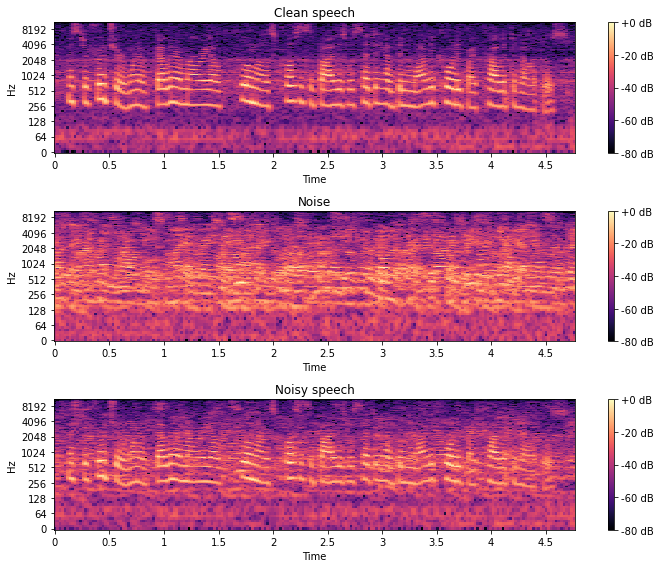

In [61]:
k = 2048
stft_mixed = compute_stft(mixed_signal, win_length= k, n_fft=k)
stft_clean = compute_stft(clean_signal, win_length= k, n_fft=k)
stft_noise = compute_stft(noise_signal, win_length= k, n_fft=k)
print(stft_mixed.shape, stft_clean.shape, stft_noise.shape)

fig, ax = plt.subplots(3,1, figsize = (10,8))
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_clean), ref=np.max), y_axis='log', x_axis='time', ax=ax[0])
ax[0].set_title('Clean speech')
fig.colorbar(img, ax=ax[0], format="%+2.0f dB")

img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_noise), ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Noise')
fig.colorbar(img, ax=ax[1], format="%+2.0f dB")

img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_mixed), ref=np.max), y_axis='log', x_axis='time', ax=ax[2])
ax[2].set_title('Noisy speech')
fig.colorbar(img, ax=ax[2], format="%+2.0f dB")
fig.tight_layout()

Dataloader

In [6]:
from torch.utils.data import Dataset
from sphfile import SPHFile
import librosa
from random import choice, randint
import os
import torch

In [2]:
def compute_stft(audio_data, win_length = 2048, hop_length = 512):
    '''
    Helper method to compute the Short Time Fourier Transform
    '''
    return librosa.stft(audio_data, win_length=win_length, hop_length=hop_length)

In [8]:
class SpeechDataset(Dataset):
    def __init__(self, split = 'train', alpha = 0.8):
        assert split in ['train', 'val', 'test'], "Invalid split"
        self.split = split
        self.noise_list = open('data/noise_list.txt').readlines()
        self.file_list = open('data/%s_set.txt'%(split)).readlines()
        #(mixed = alpha*clean + (1-alpha)*noise)
        self.alpha = alpha
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        sph_data = SPHFile(self.file_list[idx].rstrip())
        SR = sph_data.format['sample_rate'] # Sampling rate
        clean_signal = sph_data.content/(2**(sph_data.format['sample_sig_bits']-1))

        # Randomly sample noise sample from noise data list
        noise_signal = librosa.load(choice(self.noise_list).rstrip(), sr=SR)[0]
                                  
        len_signal = min(clean_signal.shape[0],noise_signal.shape[0])
        # randomly sample a window from noise sequence to be mixed
        start_n = randint(0,max(0,noise_signal.shape[0]-clean_signal.shape[0]))
        noise_signal = noise_signal[start_n: start_n+len_signal]
        clean_signal = clean_signal[0:len_signal]
        mixed_signal = self.alpha*clean_signal + (1-self.alpha)*noise_signal
                                  
        # return STFT
        stft_mixed = compute_stft(mixed_signal)
        stft_clean = compute_stft(clean_signal)
        
        return stft_mixed, stft_clean

In [9]:
def custom_collate_fn(batch):
    clean_spec = []
    noisy_spec = []
    print(len(batch))
    for i in range(len(batch)):
        clean_spec.append(torch.tensor(batch[i][1]))
        noisy_spec.append(torch.tensor(batch[i][0]))
    return noisy_spec, clean_spec

In [10]:
from torch.utils.data import DataLoader
train_dataset = SpeechDataset('train')
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=custom_collate_fn)
itr = next(iter(train_dataloader))

4


In [11]:
for k in range(len(itr[0])):
    print(itr[0][k].shape, itr[1][k].shape)

torch.Size([1025, 111]) torch.Size([1025, 111])
torch.Size([1025, 113]) torch.Size([1025, 113])
torch.Size([1025, 18]) torch.Size([1025, 18])
torch.Size([1025, 278]) torch.Size([1025, 278])
